# Fetal lung and panfetal analysis - differential expression analysis

In [2]:
import os,sys
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import numpy.random as random
import scipy
from scipy.sparse import csr_matrix
import anndata
import matplotlib.pyplot as plt

import milopy

Global seed set to 0
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [1]:
import seaborn as sns
import matplotlib

In [15]:
figdir = '/home/jovyan/mount/gdrive/fetal_immune_lung_intergration/figures/'
if not os.path.exists(figdir):
    os.mkdir(figdir)
# scv.settings.figdir = figdir
sc.settings.figdir = figdir

In [5]:
## r2py setup
# import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython


In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


### Load output of Milo analysis

See `lung_panfetal_milo.ipynb`

In [17]:
nhood_adata = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/Lung_panfetal_merged.scVI.V3.nhood_adata.h5ad")
adata = sc.read_h5ad("/nfs/team205/ed6/data/lunLung_panfetal_merged.scVI.V3.4milo.h5ad", backed=False)

In [18]:
adata.uns['nhood_adata'] = nhood_adata.copy()

In [19]:
milopy.utils.annotate_nhoods(adata[adata.obs['dataset_DA'] == 1], anno_col='celltype')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)


### DE analysis

In [21]:
def get_cells_in_nhoods(adata, nhood_ids):
    '''
    Get cells in neighbourhoods of interest, store the number of neighbourhoods for each cell in
    adata.obs['in_nhoods']
    '''
    in_nhoods = np.array(adata.obsm['nhoods'][:,nhood_ids.astype('int')].sum(1))
    adata.obs['in_nhoods'] = in_nhoods
    
def anndata2pseudobulk(adata, group_by, 
                       agg="s", 
                       min_ncells = 10,
                       use_layer = None
                      ):
    '''
    Do pseudo-bulking of raw counts in anndata object, based on a selection of columns in obs
    
    Params:
    ------
    - adata: the anndata object
    - group_by: list of obs columns to use for aggregation
    - agg: "s" for sum (if adata.X are counts), "m" for mean (if adata.X are log-counts)
    - min_ncells: minimum number of cells to keep pseudobulk sample (default: 10)
    - use_layer: which layer to use for pseudobulking (default: None, use adata.X)
    
    Returns:
    -------
    AnnData object of same n_vars as adata, but pseudobulked obs
    '''    
    if use_layer is None:
        X = adata.X.copy()
    else:
        X = adata.layers[use_layer].copy()
        
    ## Make obs for pseudobulk
    pseudobulk_obs = adata.obs[group_by].drop_duplicates()
    pseudobulk_obs = pseudobulk_obs[group_by].astype("str")
    pseudobulk_obs.index = pseudobulk_obs[group_by].agg("-".join, axis=1)
    
    ## Add column to obs assigning cells to pseudobulk samples
    adata.obs[group_by] = adata.obs[group_by].astype("str")
    adata.obs["pseudobulk_sample"] = adata.obs[group_by].agg("-".join, axis=1)
    
    ## Sum counts from same sample
    sample_dummies = pd.get_dummies(adata.obs["pseudobulk_sample"])[pseudobulk_obs.index].values
    sample_dummies = scipy.sparse.csr_matrix(sample_dummies)
    pseudobulk_X = X.T.dot(sample_dummies)
        
    ## Make new anndata object
    pseudobulk_adata = anndata.AnnData(pseudobulk_X.T, obs=pseudobulk_obs, var=adata.var)
    
    ## Add number of cells to obs 
    n_cells = adata.obs.groupby('pseudobulk_sample').count().iloc[:,0]
    n_cells.name = "n_cells"
    pseudobulk_adata.obs = pd.concat([pseudobulk_adata.obs, n_cells], axis=1)
    
    ## Filter obs by number of cells threshold
    pseudobulk_adata = pseudobulk_adata[pseudobulk_adata.obs['n_cells'] >= min_ncells].copy()
    return(pseudobulk_adata)



In [85]:
def run_glmGamPoi_DE(pbulk_adata, 
                     design = '~ Sort_id + ct_enriched',
                    ref_level = 'in_nhoods_other',
                    contrast = 'nhood_groupsin_nhoods_critical',
                     n_hvgs = 5000):
    '''
    Run R code for DE analysis with glmGamPoi
    
    Params:
    ------
    - pbulk_adata: anndata object with pseudobulked data
    - design: string storing design formula to pass to edgeR
    - ref_level: string of condition to consider as reference level (i.e. the control)
    - contrast: string of condition to consider as condition of interest
    - n_hvgs: number of highly variable genes to consider for DE testing
    '''
    
    ## Define R function
    glmgampoi_str = f'''
        library(SingleCellExperiment)
        library(glmGamPoi)
        library(scran)
        library(scater)

        run_de <- function(args){{
            pbulk_sdata_X <- args[[1]]
            pbulk_sdata_obs <- args[[2]]
            pbulk_sdata_var <- args[[3]]
            n_hvgs <- args[[4]]

            sce <- SingleCellExperiment(assays = list(counts = t(pbulk_sdata_X)), colData = pbulk_sdata_obs)
            sce <- logNormCounts(sce)

            ## Feature selection w scran (just on test cell types)
            dec <- modelGeneVar(sce)
            hvgs <- getTopHVGs(dec, n = n_hvgs)
            subset_sce <- sce[hvgs,]

            ## Fit
            fit <- glm_gp(subset_sce, design = {design}, reference_level = '{ref_level}')

            ## Test 
            de_res <- test_de(fit, contrast = '{contrast}')    
            de_res[,'gene_name'] <- pbulk_sdata_var[hvgs,]['gene_name']
            print(head(de_res))
            return(de_res)
        }}'''
    
    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP
    import rpy2.robjects as ro
    from rpy2.robjects.packages import importr
    from rpy2.robjects import pandas2ri

    from rpy2.robjects.conversion import localconverter
    
    ## Get anndata components
    pbulk_sdata_X = pbulk_adata.X.toarray().copy()
    pbulk_sdata_obs = pbulk_adata.obs.copy()
    pbulk_sdata_var = pbulk_adata.var.copy()
    
    r_pkg = STAP(glmgampoi_str, "r_pkg")
    # this was needed for the code to run on jhub
    # if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    args = [pbulk_sdata_X, pbulk_sdata_obs, pbulk_sdata_var, n_hvgs]
    de_res_df = r_pkg.run_de(args)
    with localconverter(ro.default_converter + pandas2ri.converter):
        de_res_df_py = ro.conversion.rpy2py(de_res_df)
    de_res_df_py.index = de_res_df_py['gene_name']
    return(de_res_df_py)

def find_nhood_group_markers(
    adata, 
    test_group: str,
    ctrl_group: str,
    confounders_obs = None,
    nhood_group_obs: str = 'nhood_groups',
    min_n_nhoods: int = 3,
    pbulk_use_layer: str = None,
    n_hvgs: int = 5
    ):
    '''
    Find genes differentially expressed between cells in 2 groups of neighbourhoods
    
    Params:
    -------
    - adata: AnnData object storing nhood info in adata.uns['nhood_adata']
    - design: design formula for the test, passed to glmGamPoi
    - test_group: which neighbourhood group is the test group?
    - ctrl_group: which neighbourhood group is the reference group?
    - nhood_group_obs: the column in adata.uns['nhood_adata'] storing the neighbourhood group information
    - min_n_nhoods: cells are assigned to a neighbourhood group only if it belongs to at least min_n_nhoods neighbourhoods in the group
    - pbulk_use_layer: layer storing counts (if None, adata.X is used) 
    - n_hvgs: how many HVGS to use for the DE test (the more you use, the longer it takes)
    
    Returns:
    --------
    pd.DataFrame storing DE test results
    '''

    ## Find cells in nhoods of interest
    groups = adata.uns['nhood_adata'].obs[nhood_group_obs].dropna().unique()
    for g in groups:
        nhoods_oi = adata.uns['nhood_adata'].obs_names[adata.uns['nhood_adata'].obs[nhood_group_obs] == g]
        get_cells_in_nhoods(adata, nhoods_oi)
        adata.obs[f'in_nhoods_{g}'] = adata.obs['in_nhoods'].copy()

    ## Find most representative group (cell belongs to mostly to neighbourhoods of that group)
    adata.obs['nhood_groups'] = np.nan
    adata.obs['nhood_groups'] = adata.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
    ## Keep only if cell is in at least min_n_nhoods nhoods of the same group
    adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan 

    ## Make pseudobulk adata for cells if different nhood groups and samples
    try:
        sdata = adata[~adata.obs['nhood_groups'].isna()].copy()
    except:
        sdata = adata[~adata.obs['nhood_groups'].isna()].to_memory()
    sdata.X = sdata.layers['counts'].copy()
    if confounders_obs is None:
        design = '~ nhood_groups'
        pbulk_sdata = anndata2pseudobulk(
            sdata, 
            group_by=[adata.uns['nhood_adata'].uns['sample_col'], 'nhood_groups'], 
            min_ncells=1, 
            use_layer=pbulk_use_layer)
    else:
        if isinstance(confounders_obs, str):
            confounder_obs = [confounders_obs]
        design = "~ " + ' + '.join(confounders_obs) + ' + nhood_groups'
        pbulk_sdata = anndata2pseudobulk(
            sdata, 
            group_by=[nhood_adata.uns['sample_col'], 'nhood_groups'] + confounders_obs, 
            min_ncells=1, 
            use_layer=pbulk_use_layer)

    
    de_results = run_glmGamPoi_DE(pbulk_sdata, design=design, 
                           ref_level = f'in_nhoods_{ctrl_group}', 
                           contrast = f'nhood_groupsin_nhoods_{test_group}', 
                           n_hvgs=n_hvgs)
    return(de_results)

In [158]:
import gseapy as gp
from gseapy.plot import barplot, dotplot

def run_enrichr(DE_results, alpha=0.1, 
                min_lfc = 0,
                outdir = res_dir + 'enrichr/NK/', gene_sets=['MSigDB_Hallmark_2020']):
    names = gp.get_library_name()

    up_genes = DE_results[(DE_results.adj_pval < alpha) & (DE_results.lfc > min_lfc)].index
    down_genes = DE_results[(DE_results.adj_pval < alpha) & (DE_results.lfc < - min_lfc)].index

    bg_genes = DE_results.index.unique()

    enr_up = gp.enrichr(gene_list=up_genes.tolist(),
                             gene_sets=gene_sets,
                             organism='Human', 
                             background=bg_genes.tolist(),
                             outdir=outdir + '/up_genes/',
                             cutoff=0.5 # test dataset, use lower value from range(0,1)
                            ).results
    enr_down = gp.enrichr(gene_list=down_genes.tolist(),
                             gene_sets=gene_sets,
                             organism='Human', 
                             background=bg_genes.tolist(),
                             outdir=outdir + '/down_genes/',
                             cutoff=0.5 # test dataset, use lower value from range(0,1)
                            ).results
    return(enr_up, enr_down)
    

def run_DE_analysis(ct, blacklist_genes, res_dir = '/home/jovyan/mount/gdrive/fetal_immune_lung_intergration/'):
    nhood_obs = adata.uns['nhood_adata'].obs.copy()

    ct_clusters = [ct]
    ct_nhood_obs = nhood_obs[nhood_obs['nhood_annotation'].isin(ct_clusters)].copy()

    ## Annotate lung-enriched ct nhoods (vs rest of ct nhoods)
    enr_ct = ct_nhood_obs.index[(ct_nhood_obs.logFC > 0) & (ct_nhood_obs.SpatialFDR < 0.1)]
    other_ct = ct_nhood_obs.index[~ct_nhood_obs.index.isin(enr_ct)]

    adata.uns['nhood_adata'].obs['ct_enriched'] = np.nan
    adata.uns['nhood_adata'].obs.loc[enr_ct, 'ct_enriched'] = 'ct_enriched'
    adata.uns['nhood_adata'].obs.loc[other_ct, 'ct_enriched'] = 'ct_other'

    print(adata.uns['nhood_adata'].obs['ct_enriched'].value_counts())
    
    ## Run DE testing
    DE_ct_enriched = find_nhood_group_markers(
        adata, 
        test_group='ct_enriched', 
        ctrl_group='ct_other', 
        nhood_group_obs = 'ct_enriched',
        confounders_obs=['Sort_id'],
        n_hvgs = 7500
        )
    
    ## Exclude blacklisted genes
    DE_ct_enriched = DE_ct_enriched.loc[~DE_ct_enriched.index.isin(blacklist_genes)].copy()
    
    ## Save 
    print(f'Saving {res_dir + f"{ct}_nhoods_DE_results.csv"}')
    DE_ct_enriched = DE_ct_enriched.sort_values(['adj_pval', 'lfc'])
    DE_ct_enriched.to_csv(res_dir + f"{ct}_nhoods_DE_results.csv")
    
    ## Run enrichment analysis
    print(f'Running GO enrichment analysis')
    signif_ct = DE_ct_enriched.gene_name[(DE_ct_enriched.adj_pval < 0.1)].values
    enr_up, enr_down = run_enrichr(DE_ct_enriched.loc[signif_ct], 
                                    min_lfc= 0,
                                    gene_sets=['GO_Biological_Process_2021', 'MSigDB_Hallmark_2020'],
                                   outdir = res_dir + f'enrichr/{ct}/',
                                  )

#### DE on control cell types 
Where we don't expect organ-specific differences, to rule out soup effects

In [107]:
nhood_obs = adata.uns['nhood_adata'].obs.copy()
ct_clusters = ['T progenitors', "HSC/MPP", "Immature B", 'Treg']
ct_nhood_obs = nhood_obs[nhood_obs['nhood_annotation'].isin(ct_clusters)].copy()

## Annotate lung-enriched ct nhoods (vs rest of ct nhoods)
enr_ct = ct_nhood_obs.index[(ct_nhood_obs.SpatialFDR < 0.1)]
other_ct = ct_nhood_obs.index[~ct_nhood_obs.index.isin(enr_ct)]

adata.uns['nhood_adata'].obs['ct_enriched'] = np.nan
adata.uns['nhood_adata'].obs.loc[enr_ct, 'ct_enriched'] = 'ct_enriched'
adata.uns['nhood_adata'].obs.loc[other_ct, 'ct_enriched'] = 'ct_other'

adata.uns['nhood_adata'].obs['ct_enriched'].value_counts()

ct_other       124
ct_enriched     81
Name: ct_enriched, dtype: int64

In [108]:
adata.var['gene_name'] = adata.var['GeneName'].copy()

In [109]:
## Run DE testing
DE_ct_enriched = find_nhood_group_markers(
    adata, 
    test_group='ct_enriched', 
    ctrl_group='ct_other', 
    nhood_group_obs = 'ct_enriched',
    confounders_obs=['Sort_id'],
    n_hvgs = 7500
    )


/tmp/ipykernel_735/2237602105.py:117: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/oor-benchm

     name         pval   adj_pval f_statistic df1      df2        lfc gene_name
1 row_001 0.4440856848 0.76674010  0.58915989   1 134.8887  0.4198874      IL32
2 row_002 0.0678523853 0.33805525  3.38844047   1 134.8887 -0.9700416    HSPA1A
3 row_003 0.0003190398 0.02151746 13.65024217   1 134.8887 -4.5948670   HLA-DRA
4 row_004 0.8531446194 0.96137150  0.03439646   1 134.8887 -0.1098412     RPS10
5 row_005 0.2402184240 0.61192285  1.39155843   1 134.8887 -0.5752617    HSPA1B
6 row_006 0.4563494661 0.77267539  0.55804428   1 134.8887  0.2814868       LTB


In [121]:
blacklist_genes = DE_ct_enriched[(DE_ct_enriched.adj_pval < 0.1) & (DE_ct_enriched.lfc < 0)].gene_name.values
blacklist_genes

['HLA-DRA', 'CD74', 'HLA-DPA1', 'HLA-DPB1', 'STMN1', ..., 'RGL4', 'ZFP64', 'LAMTOR1', 'ATP6V0B', 'TARBP2']
Length: 182
Categories (25058, object): ['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', ..., 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1']

### DE on cell types of interest

In [159]:
adata.var['gene_name'] = adata.var['GeneName'].copy()
run_DE_analysis(ct = 'Intermediate NK', blacklist_genes=blacklist_genes)
run_DE_analysis(ct = 'ILCP', blacklist_genes=blacklist_genes)
run_DE_analysis(ct = 'CD16+ NK', blacklist_genes=blacklist_genes)
run_DE_analysis(ct = 'DC2', blacklist_genes=blacklist_genes)
run_DE_analysis(ct = 'MΦ', blacklist_genes=blacklist_genes)
run_DE_analysis(ct = 'CD56bright NK', blacklist_genes=blacklist_genes)

ct_other       148
ct_enriched     64
Name: ct_enriched, dtype: int64


/tmp/ipykernel_735/2237602105.py:117: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/oor-benchm

     name         pval    adj_pval f_statistic df1      df2         lfc
1 row_001 0.3406059438 0.538768735  0.91441153   1 139.0699 -0.49469079
2 row_002 0.3272641029 0.525069506  0.96649103   1 139.0699 -0.63434265
3 row_003 0.8444114463 0.910254358  0.03865968   1 139.0699  0.08492285
4 row_004 0.3929465764 0.584963183  0.73436400   1 139.0699 -0.27882866
5 row_005 0.4690042077 0.654589809  0.52720579   1 139.0699  0.25885971
6 row_006 0.0000868978 0.001332224 16.34863208   1 139.0699  2.45752193
  gene_name
1    HSPA1A
2     HSPA6
3    HSPA1B
4      CCL4
5      GNLY
6 MTRNR2L12
Saving /home/jovyan/mount/gdrive/fetal_immune_lung_intergration/Intermediate NK_nhoods_DE_results.csv
Running GO enrichment analysis
ct_enriched    72
ct_other       46
Name: ct_enriched, dtype: int64


/tmp/ipykernel_735/2237602105.py:117: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/oor-benchm

     name       pval  adj_pval f_statistic df1      df2          lfc gene_name
1 row_001 0.07599043 0.2460830 3.194793735   1 143.0498  1.008264363    HSPA1A
2 row_002 0.03351779 0.1409100 4.607563090   1 143.0498  0.950038181    HSPA1B
3 row_003 0.22746165 0.4833116 1.469254068   1 143.0498  0.451292813       JUN
4 row_004 0.99168419 0.9958002 0.000109009   1 143.0498 -0.003764589     RPS10
5 row_005 0.77654525 0.9105831 0.080860961   1 143.0498 -0.105740247     RPS17
6 row_006 0.36610435 0.6329605 0.822056332   1 143.0498  0.850518400    RPS4Y1
Saving /home/jovyan/mount/gdrive/fetal_immune_lung_intergration/ILCP_nhoods_DE_results.csv
Running GO enrichment analysis
ct_other       75
ct_enriched    71
Name: ct_enriched, dtype: int64


/tmp/ipykernel_735/2237602105.py:117: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/oor-benchm

     name       pval  adj_pval f_statistic df1      df2         lfc gene_name
1 row_001 0.19410219 0.5080643  1.70430590   1 126.1265 -0.56474359    HSPA1A
2 row_002 0.02352401 0.1602412  5.25626921   1 126.1265 -1.11753377     HSPA6
3 row_003 0.02740827 0.1736730  4.97996934   1 126.1265 -0.71269974    HSPA1B
4 row_004 0.20377013 0.5196771  1.63202182   1 126.1265  0.43856951       FOS
5 row_005 0.75436727 0.8904615  0.09832479   1 126.1265  0.09827231       JUN
6 row_006 0.28451287 0.6021700  1.15521063   1 126.1265  0.40671130     DUSP2
Saving /home/jovyan/mount/gdrive/fetal_immune_lung_intergration/CD16+ NK_nhoods_DE_results.csv
Running GO enrichment analysis
ct_other       237
ct_enriched    126
Name: ct_enriched, dtype: int64


/tmp/ipykernel_735/2237602105.py:117: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/oor-benchm

     name      pval  adj_pval  f_statistic df1      df2         lfc gene_name
1 row_001 0.9779624 0.9903751 0.0007647508   1 225.9753 -0.01867799    RPS4Y1
2 row_002 0.1197171 0.3793318 2.4394489910   1 225.9753 -0.62673652      CCL4
3 row_003 0.4870895 0.7462666 0.4845375271   1 225.9753  0.27271530     HSPA6
4 row_004 0.4372719 0.7130983 0.6055775032   1 225.9753  0.31534217   ATP6V0C
5 row_005 0.8112193 0.9229906 0.0571845531   1 225.9753 -0.07654208     CXCL8
6 row_006 0.6902225 0.8668233 0.1592525423   1 225.9753  0.13651858  HLA-DQA2
Saving /home/jovyan/mount/gdrive/fetal_immune_lung_intergration/DC2_nhoods_DE_results.csv
Running GO enrichment analysis
ct_other       401
ct_enriched    103
Name: ct_enriched, dtype: int64


/tmp/ipykernel_735/2237602105.py:117: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/oor-benchm

     name         pval    adj_pval f_statistic df1     df2        lfc gene_name
1 row_001 0.1837263675 0.398948939   1.7806490   1 183.145 -0.6473422      SPP1
2 row_002 0.0004518296 0.009145068  12.7631940   1 183.145 -1.2192568      CCL4
3 row_003 0.3639106859 0.591147963   0.8284734   1 183.145  0.3225766  HLA-DPA1
4 row_004 0.0013717889 0.018419977  10.5646908   1 183.145 -1.0751895      CCL3
5 row_005 0.7397531397 0.866931431   0.1106788   1 183.145  0.1238486  HLA-DPB1
6 row_006 0.0050022976 0.045420377   8.0729322   1 183.145 -1.0984879    CCL4L2
Saving /home/jovyan/mount/gdrive/fetal_immune_lung_intergration/MΦ_nhoods_DE_results.csv
Running GO enrichment analysis
ct_other       117
ct_enriched     31
Name: ct_enriched, dtype: int64


/tmp/ipykernel_735/2237602105.py:117: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/oor-benchm

     name         pval    adj_pval f_statistic df1     df2        lfc gene_name
1 row_001 7.384554e-01 0.919853932   0.1120504   1 110.656 -0.3260447     HSPA6
2 row_002 6.269931e-01 0.887899809   0.2374842   1 110.656  0.3434564    HSPA1A
3 row_003 7.051368e-01 0.906036135   0.1439250   1 110.656  0.2263120    HSPA1B
4 row_004 1.783507e-01 0.599669247   1.8345468   1 110.656  0.6326301    DNAJB1
5 row_005 1.753441e-02 0.242062118   5.8151678   1 110.656  0.9628009     DUSP2
6 row_006 3.065955e-05 0.004975821  18.9060094   1 110.656  1.5557080       FOS
Saving /home/jovyan/mount/gdrive/fetal_immune_lung_intergration/CD56bright NK_nhoods_DE_results.csv
Running GO enrichment analysis


#### Volcano plots

In [189]:
res_dir = '/home/jovyan/mount/gdrive/fetal_immune_lung_intergration/'
DE_results_files = [res_dir + x for x in os.listdir(res_dir) if x.endswith('results.csv')]
DE_results = {x.split(res_dir)[1].split('_nhoods_DE')[0]:pd.read_csv(x) for x in DE_results_files}

for k,v in DE_results.items():
    v['ct'] = k
DE_results_all = pd.concat(DE_results.values())

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


[1] "/home/jovyan/mount/gdrive/fetal_immune_lung_intergration/figures/CD56bright NK_volcano_repel.pdf"
[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]



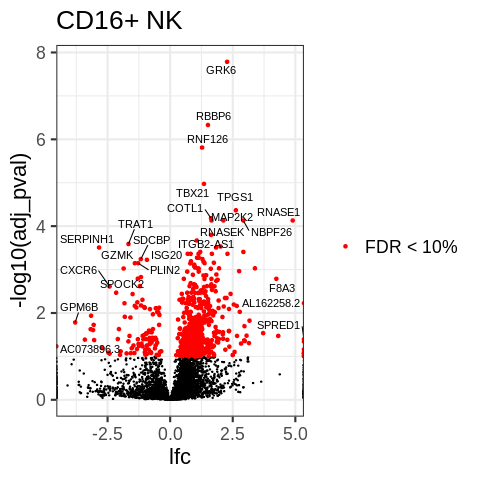

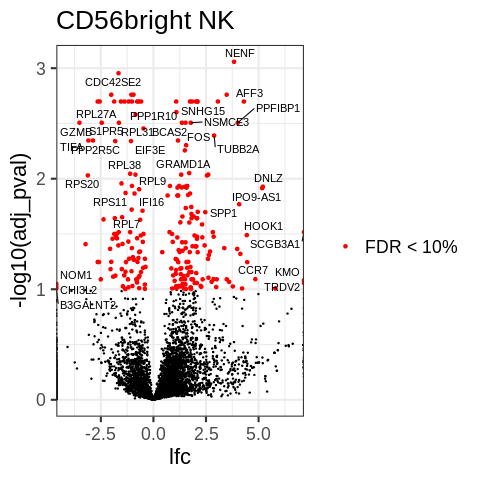

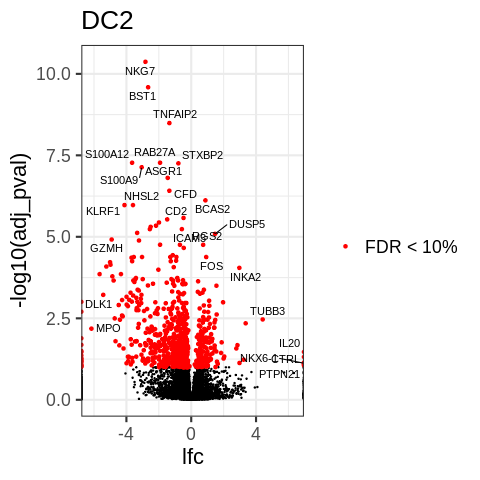

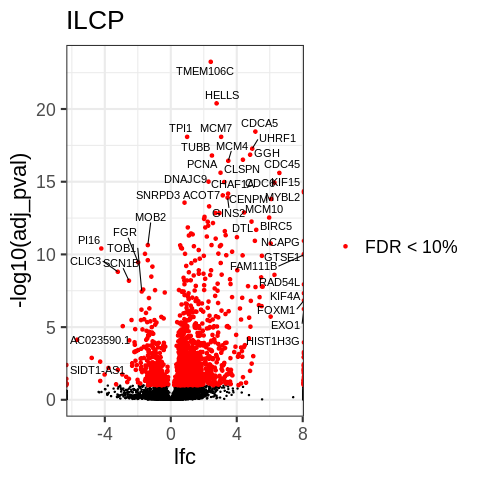

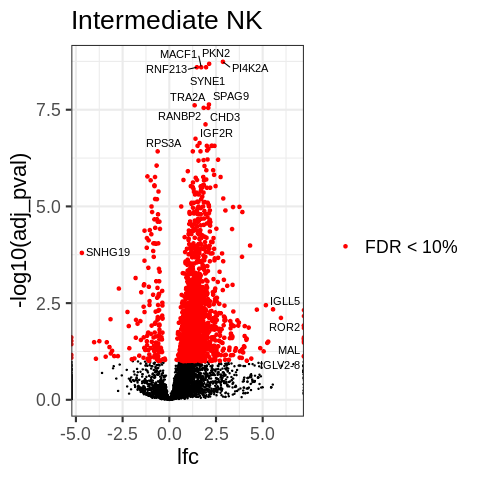

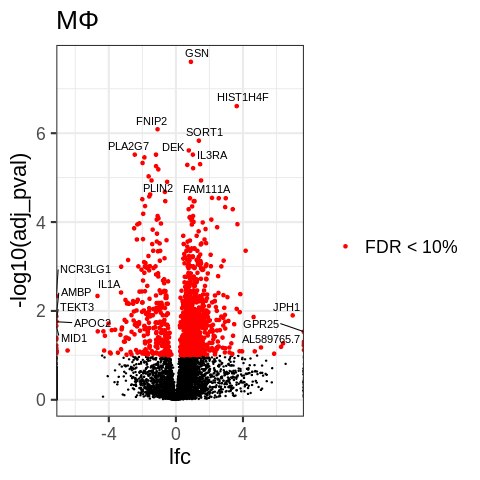

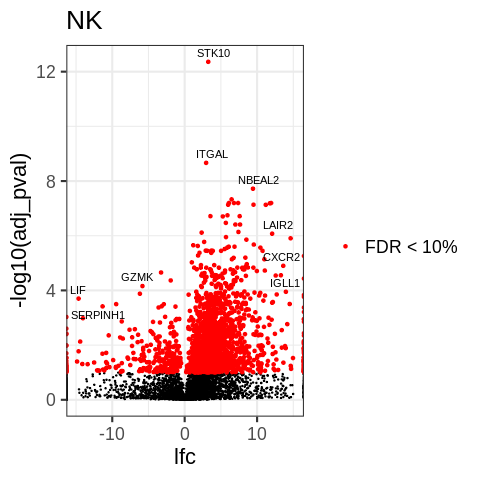

In [203]:
%%R -i DE_results_all -i figdir
max_lfc = 15

DE_results_all$lfc <- ifelse(abs(DE_results_all$lfc) > max_lfc, sign(DE_results_all$lfc) * Inf, DE_results_all$lfc)
print(paste0(figdir, ct_oi, '_volcano_repel.pdf'))
lapply(unique(DE_results_all$ct), function(ct_oi){
    DE_results_all %>%
        filter(ct == ct_oi) %>%
        mutate(signif = adj_pval < 0.1) %>%
        mutate(gene_label = ifelse(signif & (abs(lfc) > 0.5), as.character(gene_name), NA)) %>%
        ggplot(aes(lfc, -log10(adj_pval))) + 
        geom_point(size=0.5) +
        geom_point(data=. %>% filter(signif), aes(color='FDR < 10%')) +
        ggrepel::geom_text_repel(data=. %>% filter(signif), aes(label=gene_label)) +
        scale_color_manual(values='red', name='') +
        ggtitle(ct_oi) +
        theme_bw(base_size=22) +
        ggsave(paste0(figdir, ct_oi, '_volcano_repel.pdf'), height=12, width=14)
    })
